In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
pd.set_option('display.max_columns', None)

In [2]:
'''
mode1: the features may be dependent, and the covariance matrices are unique
mode2: features are independent but the covariance matrices under each class are unique
mode3: the covariance matrices under both classes are the same but the features may be dependent
mode4: covariance matrices under both classes are the same and the features are independent
'''
def trainBayesClassifier(data0, data1, mode):
    if mode=='ONE':
        mu0_hat = np.mean(data0,axis=0)
        mu1_hat = np.mean(data1,axis=0)
        cov0_hat = np.cov(data0.T)
        cov1_hat = np.cov(data1.T)
    if mode=='TWO':
        mu0_hat = np.mean(data0,axis=0)
        mu1_hat = np.mean(data1,axis=0)
        cov0_hat = np.array([[np.var(data0[:,0]),0],[0,np.var(data0[:,1])]])
        cov1_hat = np.array([[np.var(data1[:,0]),0],[0,np.var(data1[:,1])]])
    if mode=='THREE':
        mu0_hat = np.mean(data0,axis=0)
        mu1_hat = np.mean(data1,axis=0)
        data = np.concatenate(((data0 - mu0_hat),(data1 - mu1_hat)),axis=0)
        cov0_hat = np.cov(data.T)
        cov1_hat = np.cov(data.T)
    if mode=='FOUR':
        mu0_hat = np.mean(data0,axis=0)
        mu1_hat = np.mean(data1,axis=0)
        data = np.concatenate(((data0 - mu0_hat),(data1 - mu1_hat)),axis=0)
        cov0_hat = np.array([[np.var(data[:,0]),0],[0,np.var(data[:,1])]])
        cov1_hat = np.array([[np.var(data[:,0]),0],[0,np.var(data[:,1])]])
    W_0 = -1 / 2 * np.linalg.inv(cov0_hat)
    W_1 = -1 / 2 * np.linalg.inv(cov1_hat)
    w_0 = np.dot(np.linalg.inv(cov0_hat),mu0_hat)
    w_1 = np.dot(np.linalg.inv(cov1_hat),mu1_hat)
    w_00 = -1 / 2 * np.dot(np.dot(mu0_hat,np.linalg.inv(cov0_hat)),mu0_hat) - 1 / 2 * np.log(np.linalg.det(cov0_hat))
    w_10 = -1 / 2 * np.dot(np.dot(mu1_hat,np.linalg.inv(cov1_hat)),mu1_hat) - 1 / 2 * np.log(np.linalg.det(cov1_hat))
    return W_0, W_1, w_0, w_1, w_00, w_10

def runBayesClassifier(W_0, W_1, w_0, w_1, w_00, w_10, X_test):
    g0 = np.array([np.dot(np.dot(x_test,W_0),x_test) + np.dot(w_0,x_test) + w_00 for x_test in X_test])
    g1 = np.array([np.dot(np.dot(x_test,W_1),x_test) + np.dot(w_1,x_test) + w_10 for x_test in X_test])
    g = g1 - g0
    predict = g.copy()
    predict[predict>=0] = 1
    predict[predict<0] = 0
    return g, predict

In [3]:
def trainLDA(data0, data1):
    mu0 = np.mean(data0,axis=0)
    mu1 = np.mean(data1,axis=0)
    data = np.concatenate(((data0 - mu0),(data1 - mu1)),axis=0)
    cov = np.cov(data.T)
    w = np.dot(np.linalg.inv(cov), mu1-mu0)
    return w

def runLDA(w, X_test):
    lam = np.dot(X_test, w)
    predict = lam.copy()
    predict[predict>=0] = 1
    predict[predict<0] = 0
    return lam, predict

In [4]:
cancer = load_breast_cancer()
data_m = cancer.data[cancer.target==0]
data_b = cancer.data[cancer.target==1]
X = cancer.data
X_std = StandardScaler().fit_transform(X)
y = cancer.target
X_e = np.concatenate((X[:,0:2], X[:,4:6], X[:,8:12], X[:,14:16], X[:,18:22], X[:,24:26], X[:,28:30]), axis=1)
X_e.shape

(569, 18)

In [5]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
X_tsne = TSNE(n_components=2,random_state=0).fit_transform(X_std)
indices = np.arange(569)
kf = KFold(n_splits=5)
pca = PCA(n_components=15)

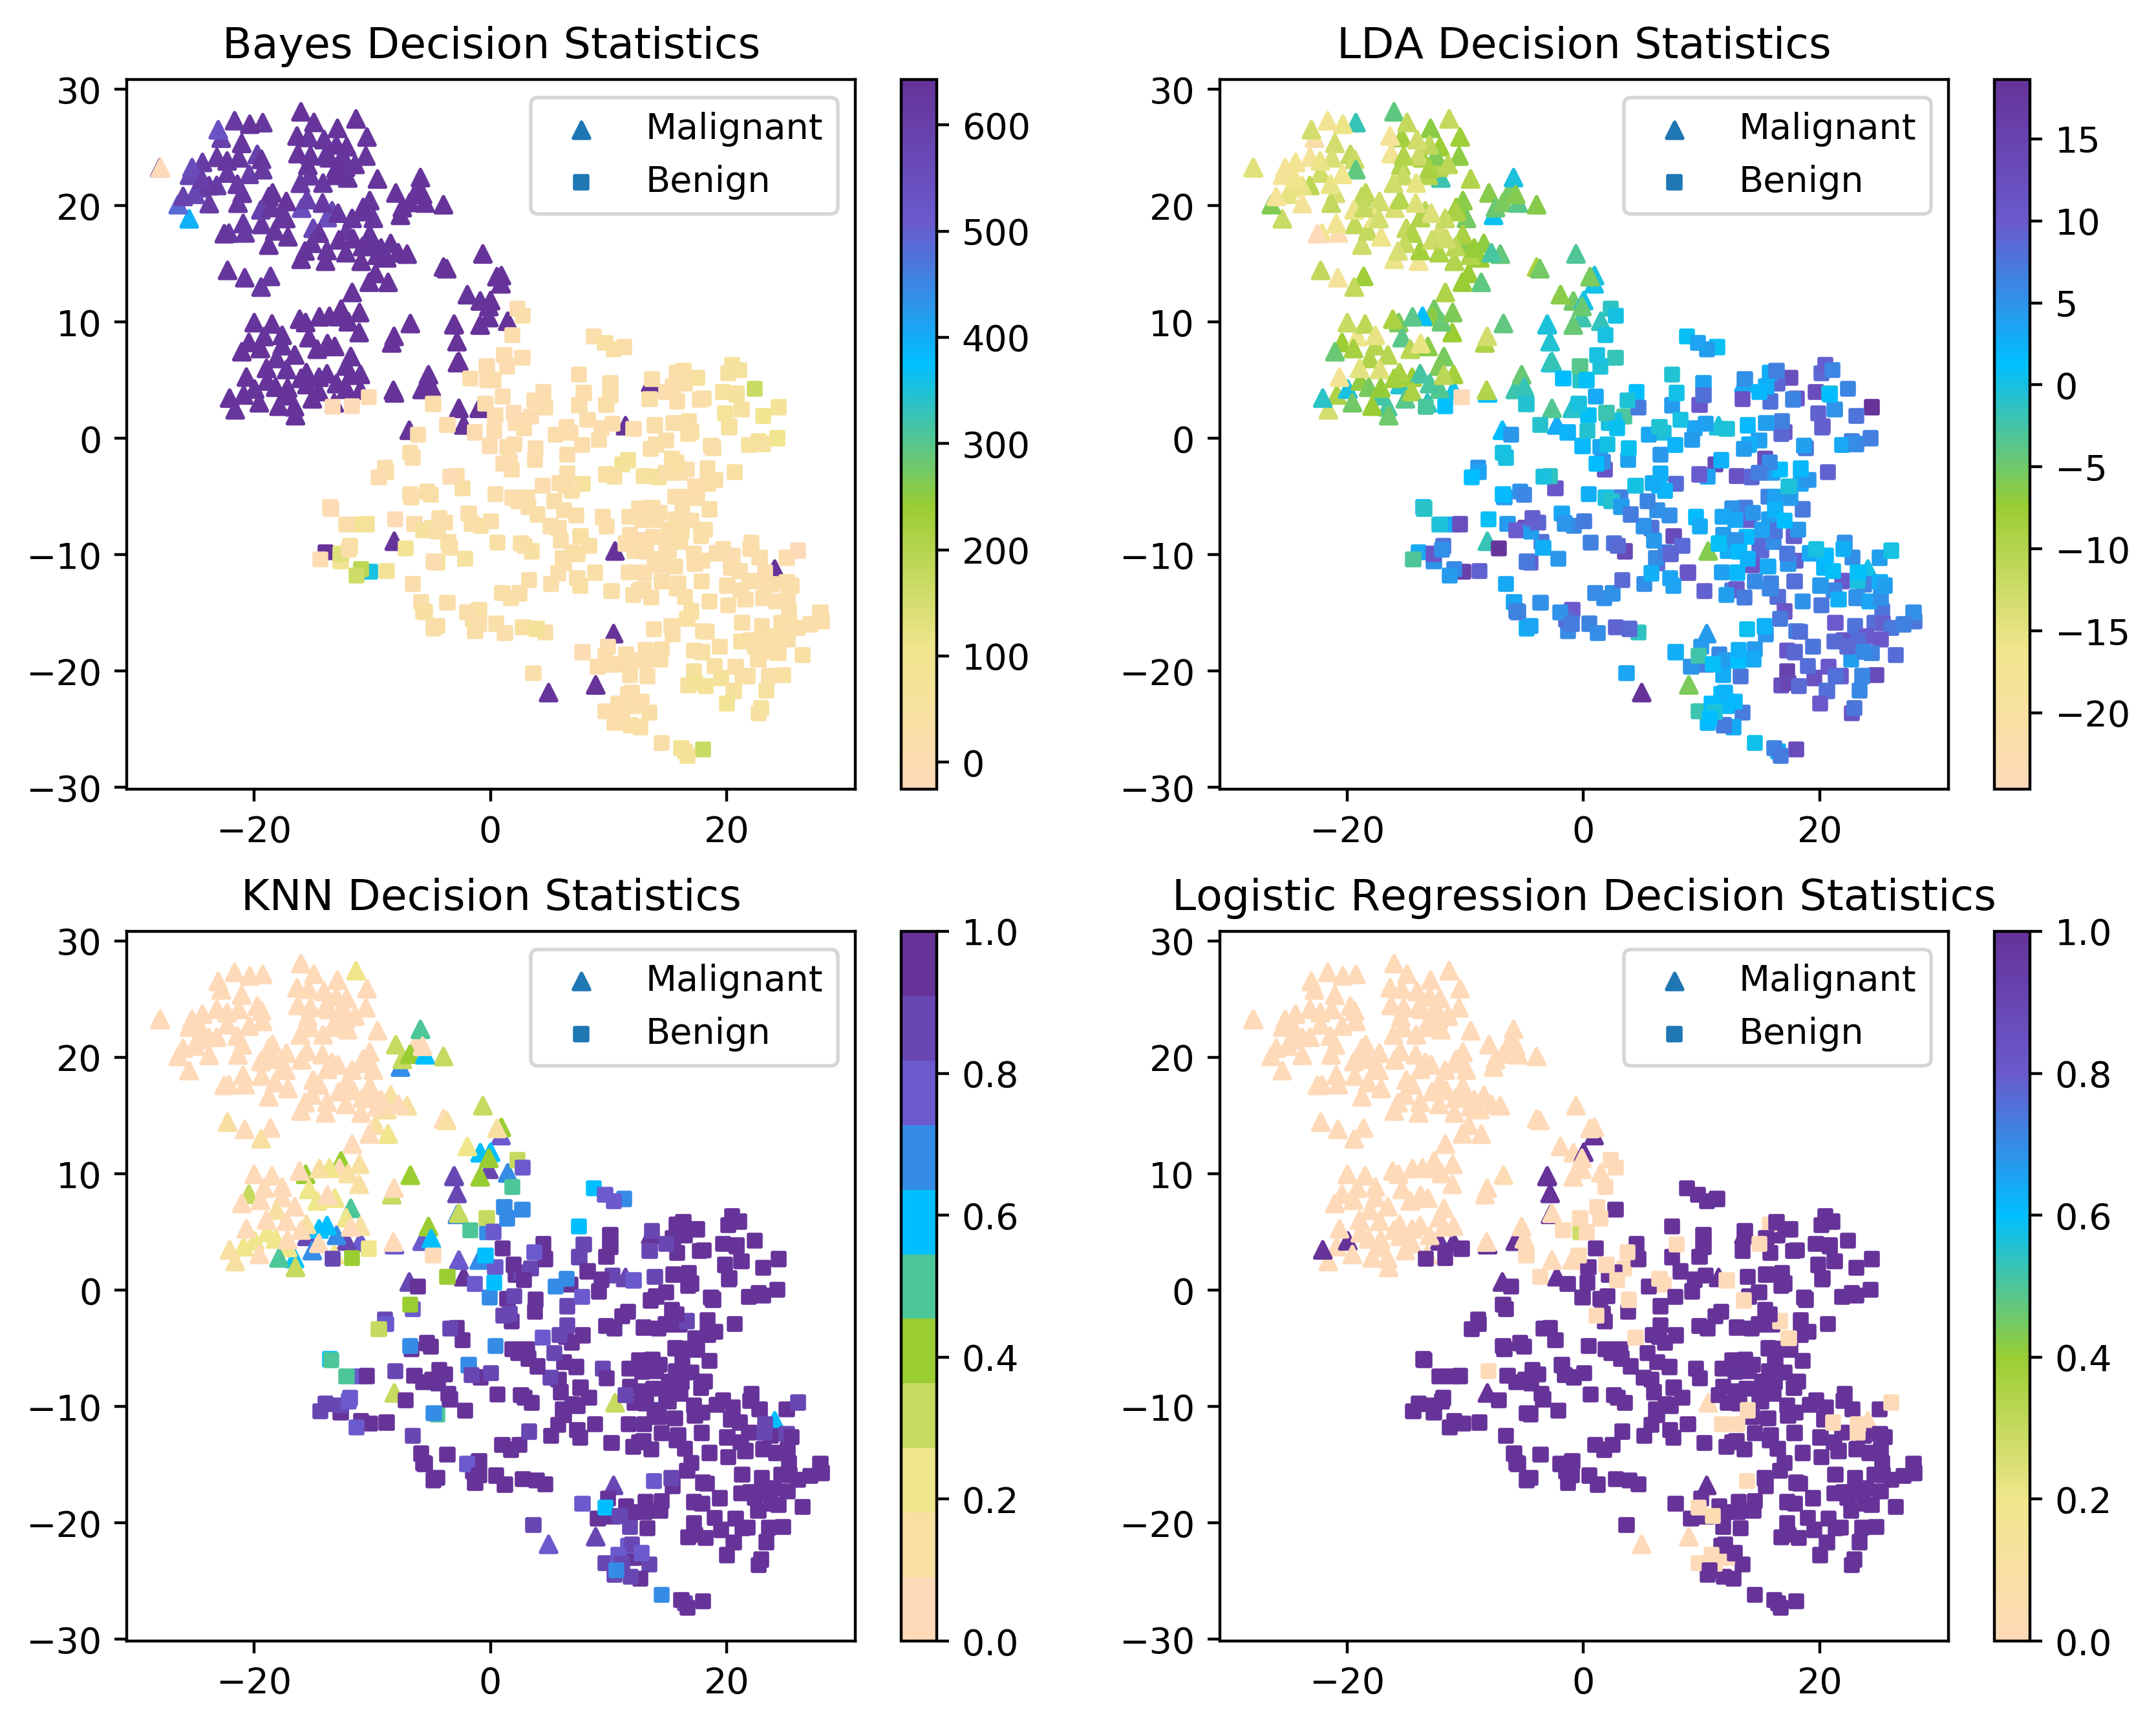

In [6]:
scores_knn = np.array([])
accuracy_knn = np.array([])
scores_bayes = np.array([])
accuracy_bayes = np.array([])
scores_lr = np.array([])
accuracy_lr = np.array([])
scores_lda = np.array([])
accuracy_lda = np.array([])
accuracy_svm = np.array([])
for train, test in kf.split(indices):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    X_train_std = StandardScaler().fit_transform(X_train)
    X_test_std = StandardScaler().fit_transform(X_test)
    clf_knn = KNeighborsClassifier(n_neighbors=10)
    clf_knn.fit(X_train_std, y_train)
    scores_new_knn = clf_knn.predict_proba(X_test_std)[:,1]
    scores_knn = np.concatenate((scores_knn, scores_new_knn))
    accuracy_new_knn = clf_knn.score(X_test_std, y_test)
    accuracy_knn = np.concatenate((accuracy_knn, [accuracy_new_knn]))
    W_0, W_1, w_0, w_1, w_00, w_10 = trainBayesClassifier(X_train[y_train==0], X_train[y_train==1], 'ONE')
    scores_new_bayes, predict_bayes = runBayesClassifier(W_0, W_1, w_0, w_1, w_00, w_10, X_test)
    scores_bayes = np.concatenate((scores_bayes, scores_new_bayes))
    accuracy_new_bayes = np.sum(predict_bayes==y_test) / y_test.shape[0]
    accuracy_bayes = np.concatenate((accuracy_bayes, [accuracy_new_bayes]))
    clf_lr = LogisticRegression(C=1e9, solver='newton-cg').fit(X_train_std,y_train)
    scores_new_lr = clf_lr.predict_proba(X_test_std)[:,1]
    scores_lr = np.concatenate((scores_lr, scores_new_lr))
    accuracy_new_lr = clf_lr.score(X_test_std, y_test)
    accuracy_lr = np.concatenate((accuracy_lr, [accuracy_new_lr]))
    clf_svm = SVC(C=10,gamma='auto').fit(X_train_std,y_train)
    accuracy_new_svm = clf_svm.score(X_test_std, y_test)
    accuracy_svm = np.concatenate((accuracy_svm, [accuracy_new_svm]))
    w = trainLDA(X_train_std[y_train==0], X_train_std[y_train==1])
    scores_new_lda, predict_lda = runLDA(w, X_test_std)
    scores_lda = np.concatenate((scores_lda, scores_new_lda))
    accuracy_new_lda = np.sum(predict_lda==y_test) / y_test.shape[0]
    accuracy_lda = np.concatenate((accuracy_lda, [accuracy_new_lda]))
    
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y, scores_knn)
auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_bayes, tpr_bayes, thresholds_bayes = metrics.roc_curve(y, scores_bayes)
auc_bayes = metrics.auc(fpr_bayes, tpr_bayes)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y, scores_lr)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
fpr_lda, tpr_lda, thresholds_lda = metrics.roc_curve(y, scores_lda)
auc_lda = metrics.auc(fpr_lda, tpr_lda)

fig = plt.figure(dpi=400, figsize=(10,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
colors = ['peachpuff','khaki','yellowgreen','deepskyblue','slateblue','rebeccapurple']
cm = LinearSegmentedColormap.from_list('my', colors, N=1000)
scores_bayes_normed = scores_bayes / 1000
score_min = np.sort(scores_bayes_normed)[1]
score_max = np.sort(scores_bayes_normed)[-2]
scores0 = scores_bayes[y==0]
scores1 = scores_bayes[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
ax1.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
im1 = ax1.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
fig.colorbar(im1, ax=ax1)
ax1.set_title("Bayes Decision Statistics")
ax1.legend()
score_min = np.amin(scores_lda)
score_max = np.amax(scores_lda)
scores0 = scores_lda[y==0]
scores1 = scores_lda[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
ax2.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
im2 = ax2.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
fig.colorbar(im2, ax=ax2)
ax2.set_title("LDA Decision Statistics")
ax2.legend()
cm = LinearSegmentedColormap.from_list('my', colors, N=11)
score_min = np.amin(scores_knn)
score_max = np.amax(scores_knn)
scores0 = scores_knn[y==0]
scores1 = scores_knn[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
ax3.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
im3 = ax3.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
fig.colorbar(im3, ax=ax3)
ax3.set_title("KNN Decision Statistics")
ax3.legend()
cm = LinearSegmentedColormap.from_list('my', colors, N=1000)
score_min = np.amin(scores_lr)
score_max = np.amax(scores_lr)
scores0 = scores_lr[y==0]
scores1 = scores_lr[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
ax4.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
im4 = ax4.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
fig.colorbar(im4, ax=ax4)
ax4.set_title("Logistic Regression Decision Statistics")
ax4.legend()

Text(0.5, 1.0, 'Receiver Operating Characteristic (PCA)')

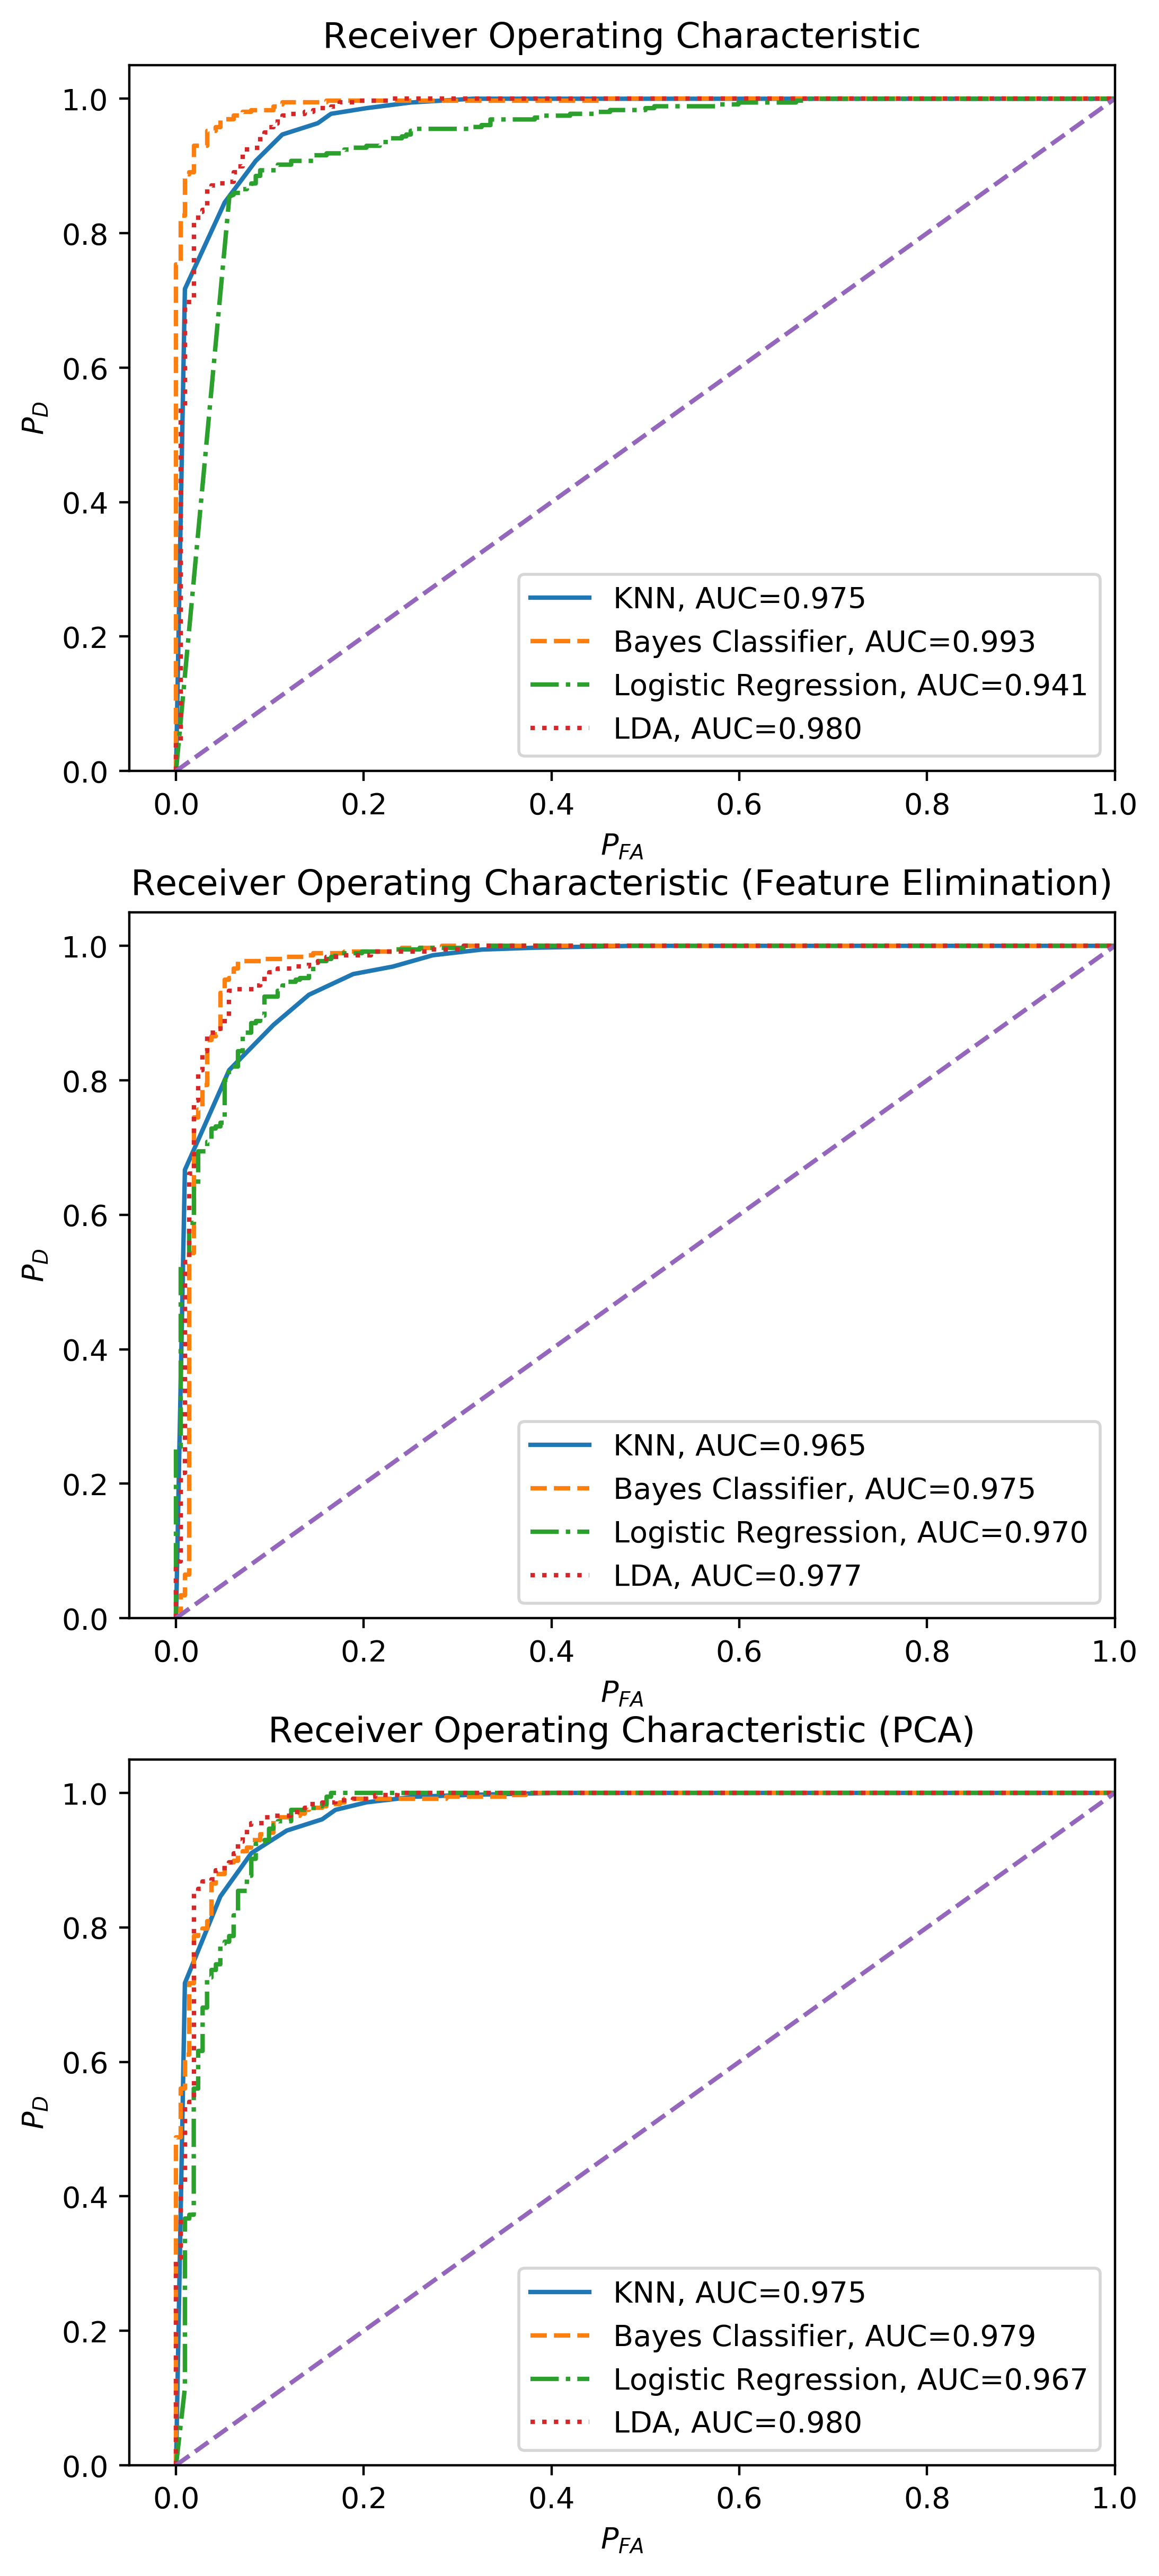

In [7]:
fig = plt.figure(dpi=400, figsize=(6, 15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(fpr_knn, tpr_knn, label='KNN, AUC=%.3f' %auc_knn, linestyle='-')
ax1.plot(fpr_bayes, tpr_bayes, label='Bayes Classifier, AUC=%.3f' %auc_bayes, linestyle='--')
ax1.plot(fpr_lr, tpr_lr, label='Logistic Regression, AUC=%.3f' %auc_lr, linestyle='-.')
ax1.plot(fpr_lda, tpr_lda, label='LDA, AUC=%.3f' %auc_lda, linestyle=':')
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('$P_{FA}$')
ax1.set_ylabel('$P_D$')
ax1.legend(loc="lower right")
ax1.set_title('Receiver Operating Characteristic')

scores_knn = np.array([])
accuracy_knn_e = np.array([])
scores_bayes = np.array([])
accuracy_bayes_e = np.array([])
scores_lr = np.array([])
accuracy_lr_e = np.array([])
scores_lda = np.array([])
accuracy_lda_e = np.array([])
accuracy_svm_e = np.array([])
for train, test in kf.split(indices):
    X_train, X_test, y_train, y_test = X_e[train], X_e[test], y[train], y[test]
    X_train_std = StandardScaler().fit_transform(X_train)
    X_test_std = StandardScaler().fit_transform(X_test)
    clf_knn = KNeighborsClassifier(n_neighbors=10)
    clf_knn.fit(X_train_std, y_train)
    scores_new_knn = clf_knn.predict_proba(X_test_std)[:,1]
    scores_knn = np.concatenate((scores_knn, scores_new_knn))
    accuracy_new_knn = clf_knn.score(X_test_std, y_test)
    accuracy_knn_e = np.concatenate((accuracy_knn_e, [accuracy_new_knn]))
    W_0, W_1, w_0, w_1, w_00, w_10 = trainBayesClassifier(X_train[y_train==0], X_train[y_train==1], 'ONE')
    scores_new_bayes, predict = runBayesClassifier(W_0, W_1, w_0, w_1, w_00, w_10, X_test)
    scores_bayes = np.concatenate((scores_bayes, scores_new_bayes))
    accuracy_new_bayes = np.sum(predict==y_test) / y_test.shape[0]
    accuracy_bayes_e = np.concatenate((accuracy_bayes_e, [accuracy_new_bayes]))
    clf_lr = LogisticRegression(C=1e9, solver='newton-cg').fit(X_train_std,y_train)
    scores_new_lr = clf_lr.predict_proba(X_test_std)[:,1]
    scores_lr = np.concatenate((scores_lr, scores_new_lr))
    accuracy_new_lr = clf_lr.score(X_test_std, y_test)
    accuracy_lr_e = np.concatenate((accuracy_lr_e, [accuracy_new_lr]))
    clf_svm = SVC(C=10,gamma='auto').fit(X_train_std,y_train)
    accuracy_new_svm = clf_svm.score(X_test_std, y_test)
    accuracy_svm_e = np.concatenate((accuracy_svm_e, [accuracy_new_svm]))
    w = trainLDA(X_train_std[y_train==0], X_train_std[y_train==1])
    scores_new_lda, predict_lda = runLDA(w, X_test_std)
    scores_lda = np.concatenate((scores_lda, scores_new_lda))
    accuracy_new_lda = np.sum(predict_lda==y_test) / y_test.shape[0]
    accuracy_lda_e = np.concatenate((accuracy_lda_e, [accuracy_new_lda]))
    
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y, scores_knn)
auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_bayes, tpr_bayes, thresholds_bayes = metrics.roc_curve(y, scores_bayes)
auc_bayes = metrics.auc(fpr_bayes, tpr_bayes)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y, scores_lr)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
fpr_lda, tpr_lda, thresholds_lda = metrics.roc_curve(y, scores_lda)
auc_lda = metrics.auc(fpr_lda, tpr_lda)
ax2.plot(fpr_knn, tpr_knn, label='KNN, AUC=%.3f' %auc_knn, linestyle='-')
ax2.plot(fpr_bayes, tpr_bayes, label='Bayes Classifier, AUC=%.3f' %auc_bayes, linestyle='--')
ax2.plot(fpr_lr, tpr_lr, label='Logistic Regression, AUC=%.3f' %auc_lr, linestyle='-.')
ax2.plot(fpr_lda, tpr_lda, label='LDA, AUC=%.3f' %auc_lda, linestyle=':')
ax2.plot([0, 1], [0, 1], linestyle='--')
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('$P_{FA}$')
ax2.set_ylabel('$P_D$')
ax2.legend(loc="lower right")
ax2.set_title('Receiver Operating Characteristic (Feature Elimination)')

scores_knn = np.array([])
accuracy_knn_p = np.array([])
scores_bayes = np.array([])
accuracy_bayes_p = np.array([])
scores_lr = np.array([])
accuracy_lr_p = np.array([])
scores_lda = np.array([])
accuracy_lda_p = np.array([])
accuracy_svm_p = np.array([])
for train, test in kf.split(indices):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    X_train_std = StandardScaler().fit_transform(X_train)
    X_test_std = StandardScaler().fit_transform(X_test)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    clf_knn = KNeighborsClassifier(n_neighbors=10)
    clf_knn.fit(X_train_pca, y_train)
    scores_new_knn = clf_knn.predict_proba(X_test_pca)[:,1]
    scores_knn = np.concatenate((scores_knn, scores_new_knn))
    accuracy_new_knn = clf_knn.score(X_test_pca, y_test)
    accuracy_knn_p = np.concatenate((accuracy_knn_p, [accuracy_new_knn]))
    W_0, W_1, w_0, w_1, w_00, w_10 = trainBayesClassifier(X_train_pca[y_train==0], X_train_pca[y_train==1], 'ONE')
    scores_new_bayes, predict = runBayesClassifier(W_0, W_1, w_0, w_1, w_00, w_10, X_test_pca)
    scores_bayes = np.concatenate((scores_bayes, scores_new_bayes))
    accuracy_new_bayes = np.sum(predict==y_test) / y_test.shape[0]
    accuracy_bayes_p = np.concatenate((accuracy_bayes_p, [accuracy_new_bayes]))
    clf_lr = LogisticRegression(C=1e9, solver='newton-cg').fit(X_train_pca,y_train)
    scores_new_lr = clf_lr.predict_proba(X_test_pca)[:,1]
    scores_lr = np.concatenate((scores_lr, scores_new_lr))
    accuracy_new_lr = clf_lr.score(X_test_pca, y_test)
    accuracy_lr_p = np.concatenate((accuracy_lr_p, [accuracy_new_lr]))
    clf_svm = SVC(C=10,gamma='auto').fit(X_train_pca,y_train)
    accuracy_new_svm = clf_svm.score(X_test_pca, y_test)
    accuracy_svm_p = np.concatenate((accuracy_svm_p, [accuracy_new_svm]))
    w = trainLDA(X_train_pca[y_train==0], X_train_pca[y_train==1])
    scores_new_lda, predict_lda = runLDA(w, X_test_pca)
    scores_lda = np.concatenate((scores_lda, scores_new_lda))
    accuracy_new_lda = np.sum(predict_lda==y_test) / y_test.shape[0]
    accuracy_lda_p = np.concatenate((accuracy_lda_p, [accuracy_new_lda]))
    
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y, scores_knn)
auc_knn = metrics.auc(fpr_knn, tpr_knn)
fpr_bayes, tpr_bayes, thresholds_bayes = metrics.roc_curve(y, scores_bayes)
auc_bayes = metrics.auc(fpr_bayes, tpr_bayes)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y, scores_lr)
auc_lr = metrics.auc(fpr_lr, tpr_lr)
fpr_lda, tpr_lda, thresholds_lda = metrics.roc_curve(y, scores_lda)
auc_lda = metrics.auc(fpr_lda, tpr_lda)
ax3.plot(fpr_knn, tpr_knn, label='KNN, AUC=%.3f' %auc_knn, linestyle='-')
ax3.plot(fpr_bayes, tpr_bayes, label='Bayes Classifier, AUC=%.3f' %auc_bayes, linestyle='--')
ax3.plot(fpr_lr, tpr_lr, label='Logistic Regression, AUC=%.3f' %auc_lr, linestyle='-.')
ax3.plot(fpr_lda, tpr_lda, label='LDA, AUC=%.3f' %auc_lda, linestyle=':')
ax3.plot([0, 1], [0, 1], linestyle='--')
ax3.set_xlim([-0.05, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('$P_{FA}$')
ax3.set_ylabel('$P_D$')
ax3.legend(loc="lower right")
ax3.set_title('Receiver Operating Characteristic (PCA)')

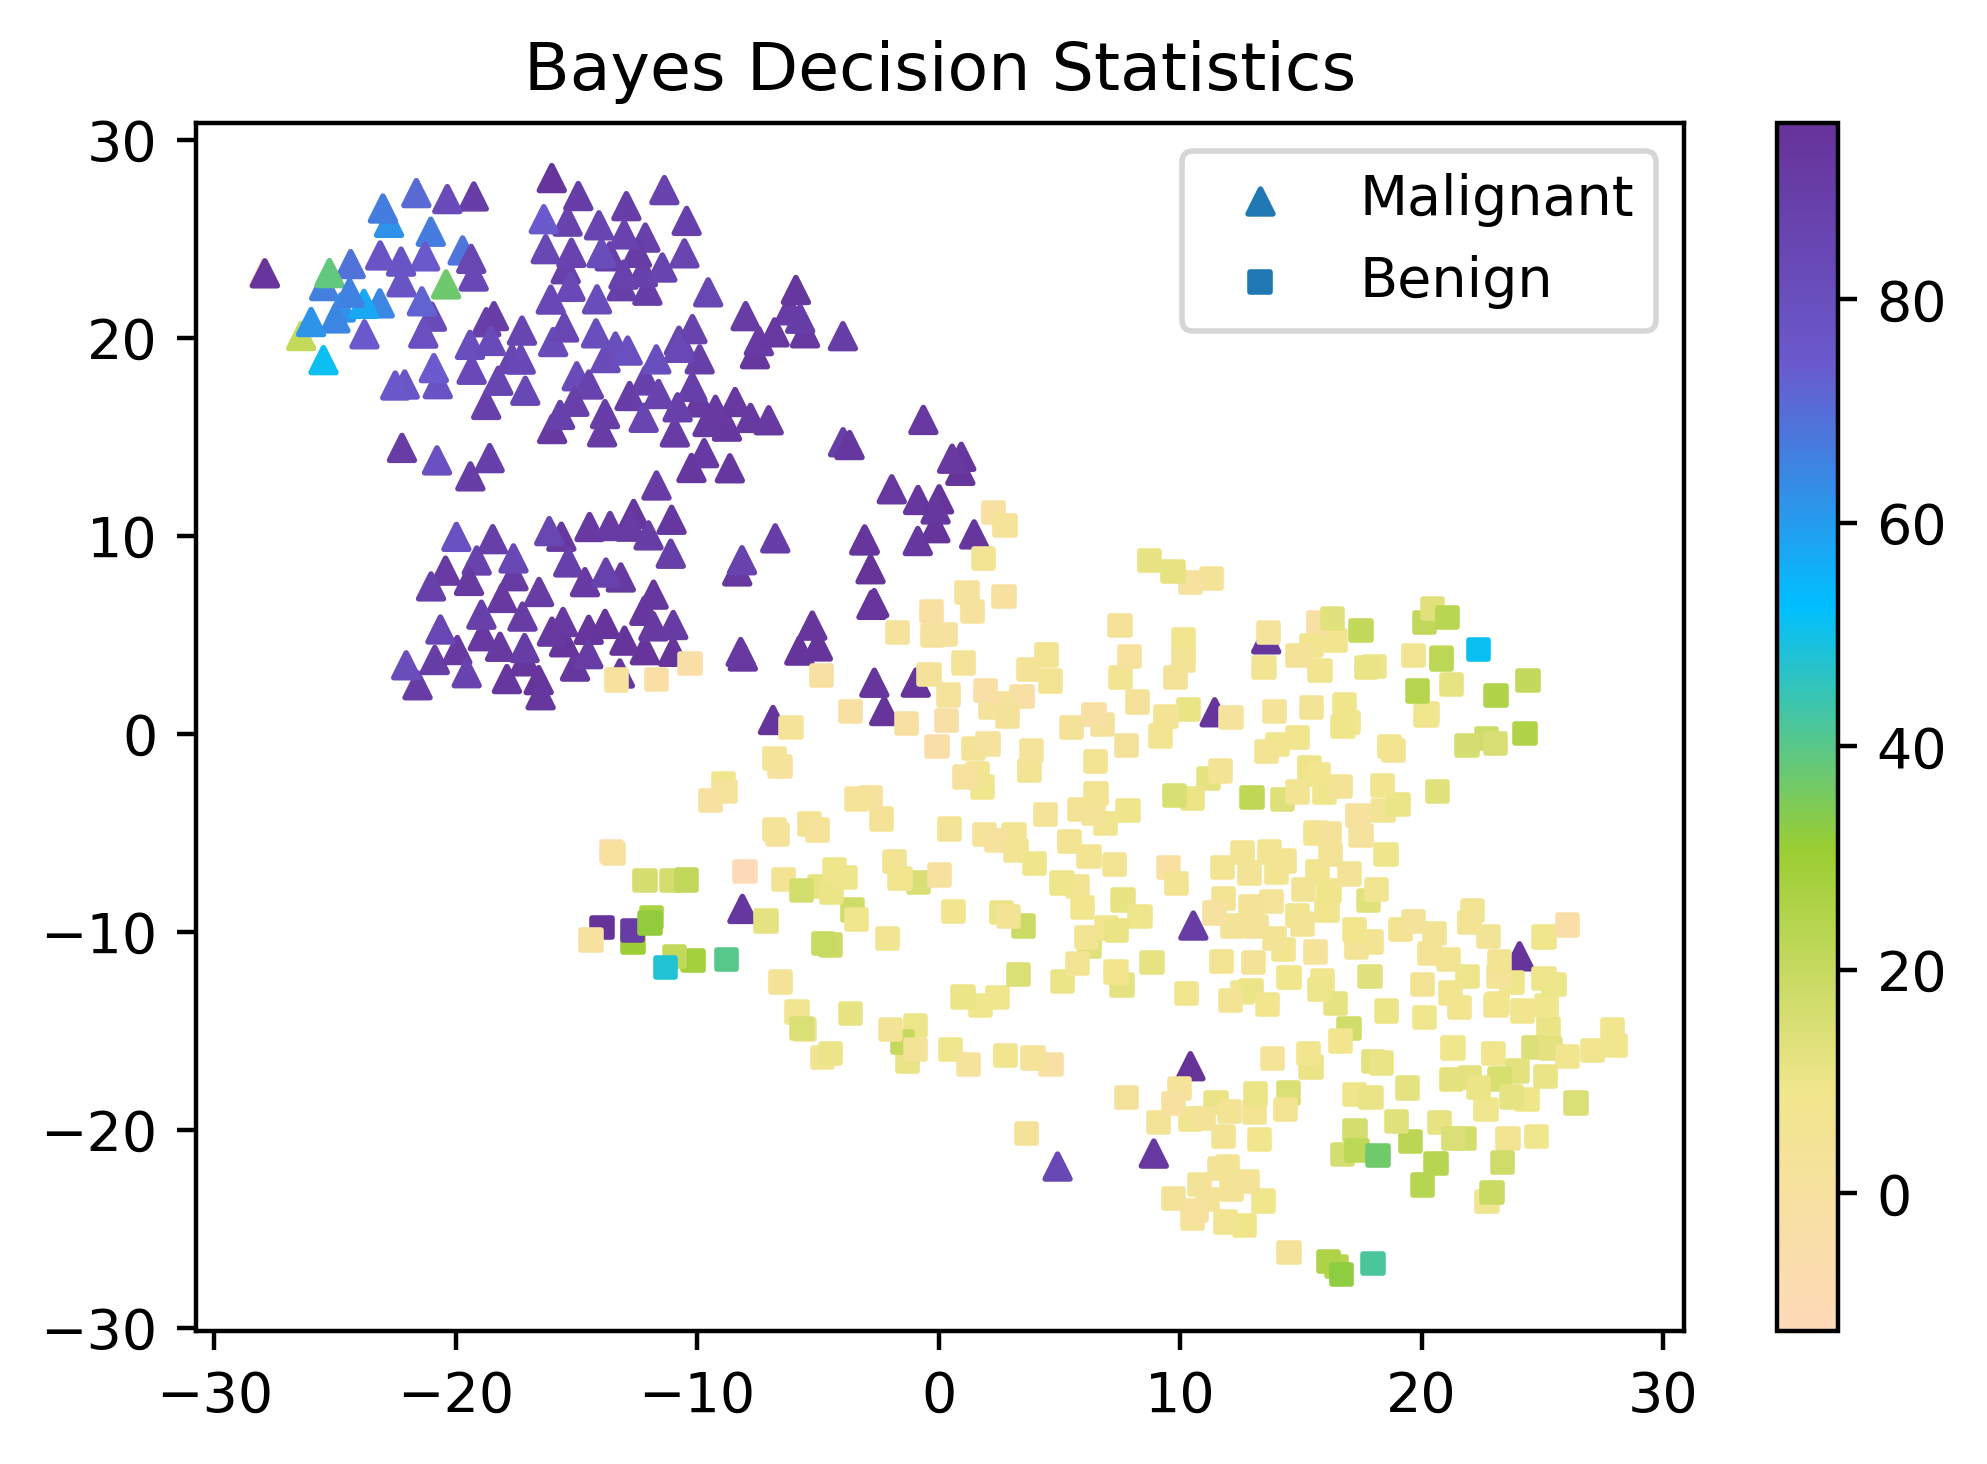

In [8]:
#colors1 = ['peachpuff','khaki','yellowgreen']
#colors2 = ['deepskyblue','slateblue','rebeccapurple']
colors = ['peachpuff','khaki','yellowgreen','deepskyblue','slateblue','rebeccapurple']
cm = LinearSegmentedColormap.from_list('my', colors, N=1000)
#cm1 = LinearSegmentedColormap.from_list('my1', colors1, N=1000)
#cm2 = LinearSegmentedColormap.from_list('my2', colors2, N=1000)
scores_bayes_normed = scores_bayes / 1000
score_min = np.sort(scores_bayes_normed)[1]
score_max = np.sort(scores_bayes_normed)[-2]
scores0 = scores_bayes[y==0]
scores1 = scores_bayes[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
plt.figure(dpi=400)
plt.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
plt.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
plt.colorbar()
plt.title("Bayes Decision Statistics")
plt.legend()

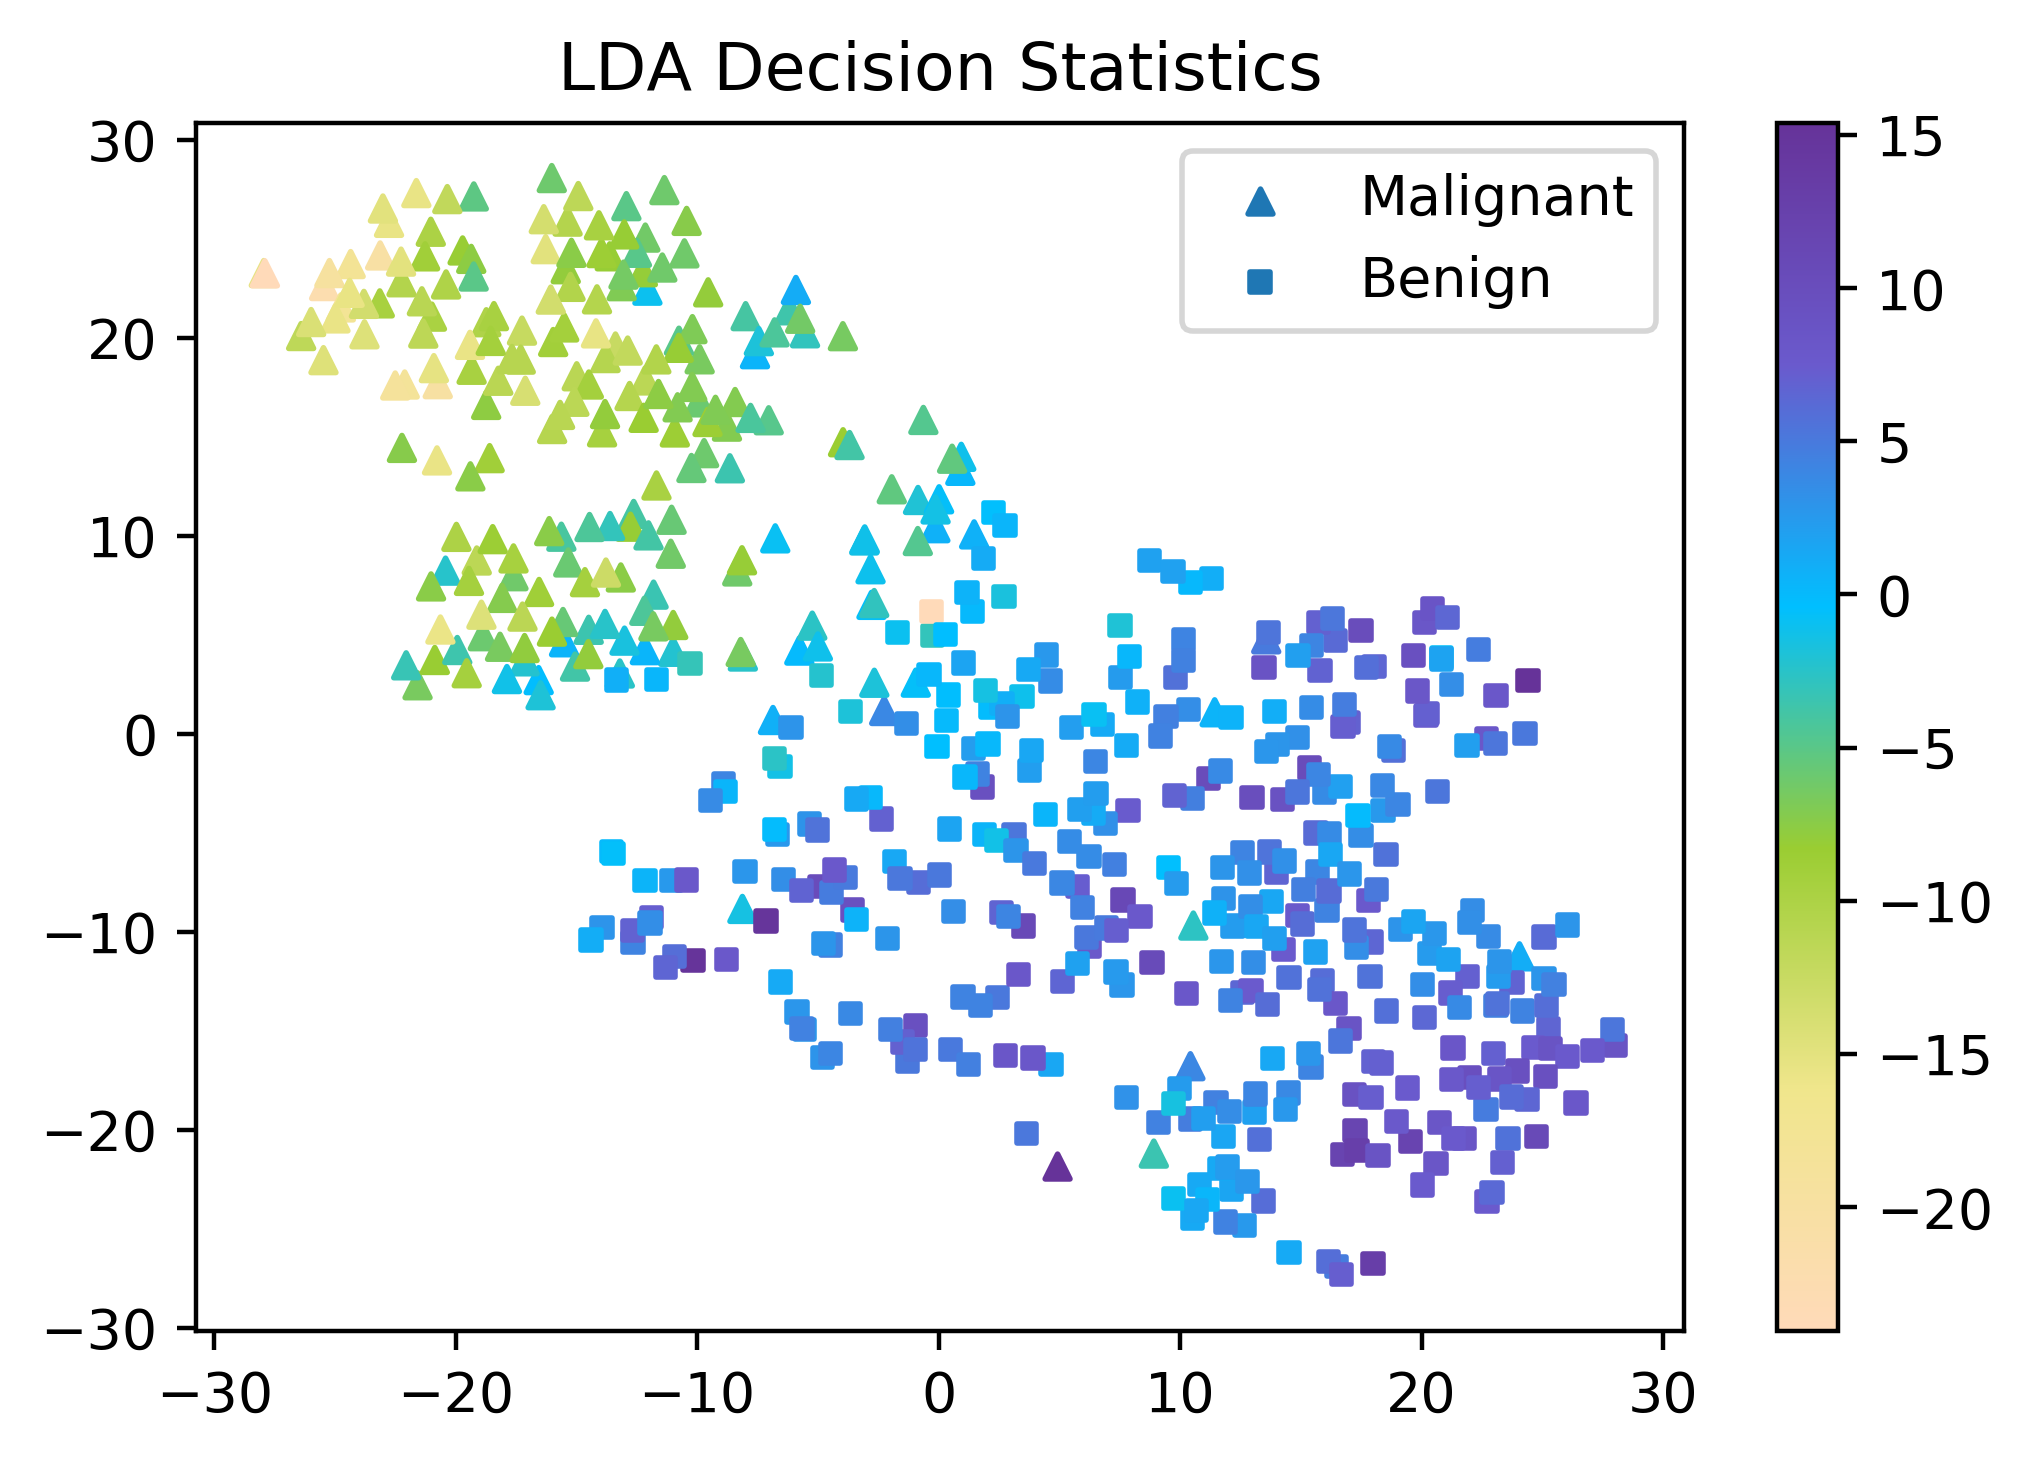

In [9]:
score_min = np.amin(scores_lda)
score_max = np.amax(scores_lda)
scores0 = scores_lda[y==0]
scores1 = scores_lda[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
plt.figure(dpi=400)
plt.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
plt.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
plt.colorbar()
plt.title("LDA Decision Statistics")
plt.legend()

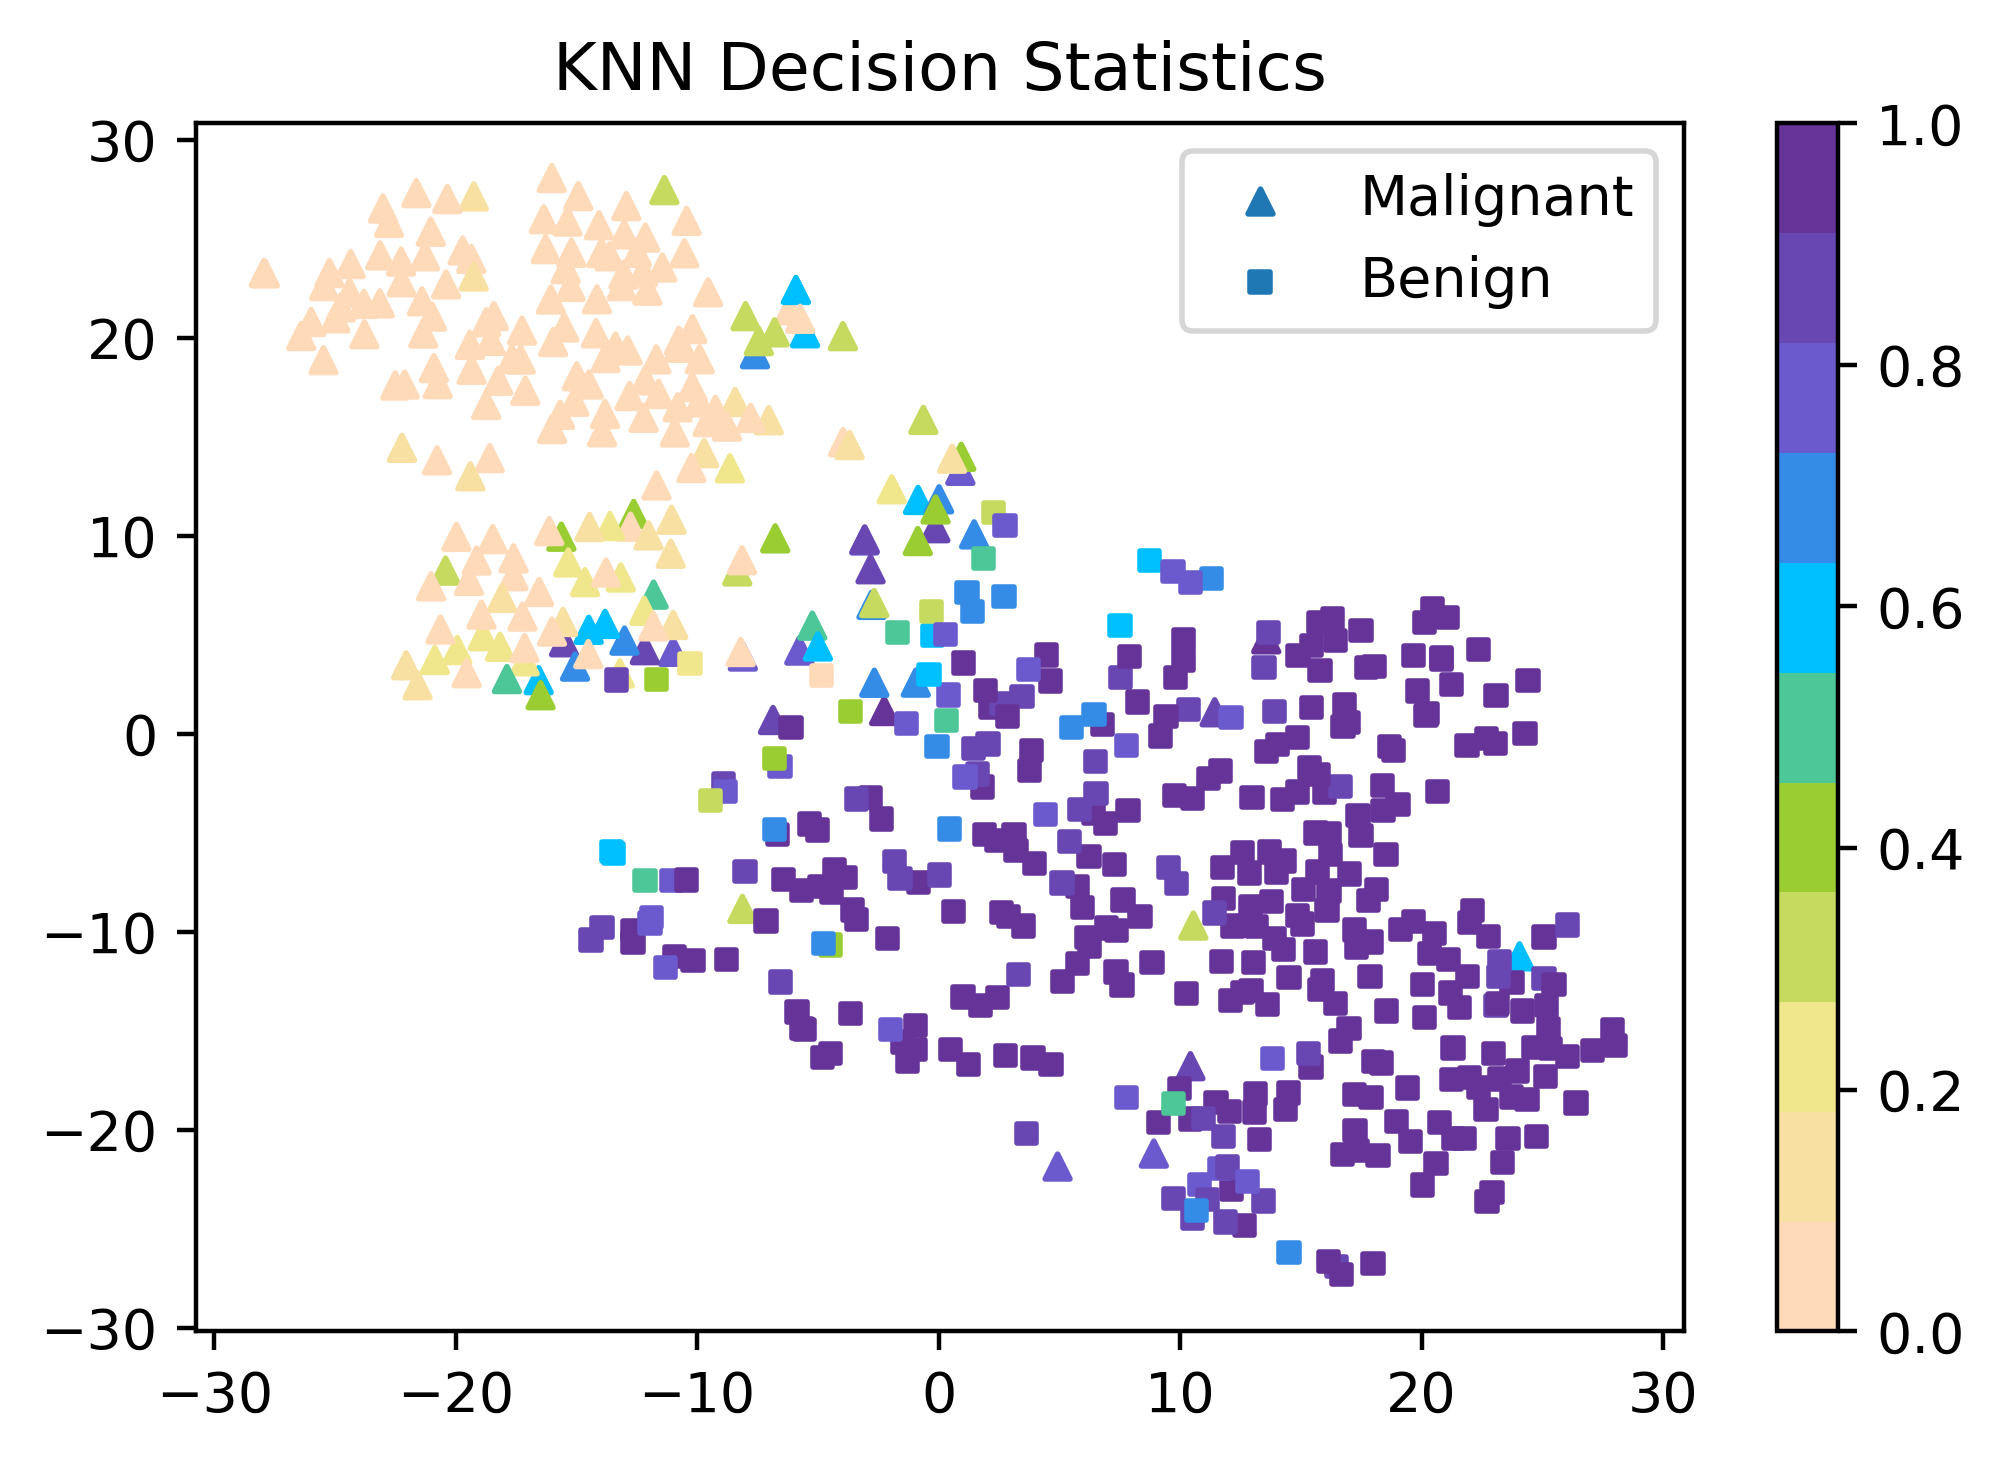

In [10]:
cm = LinearSegmentedColormap.from_list('my', colors, N=11)
score_min = np.amin(scores_knn)
score_max = np.amax(scores_knn)
scores0 = scores_knn[y==0]
scores1 = scores_knn[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
plt.figure(dpi=400)
plt.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
plt.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
plt.colorbar()
plt.title("KNN Decision Statistics")
plt.legend()

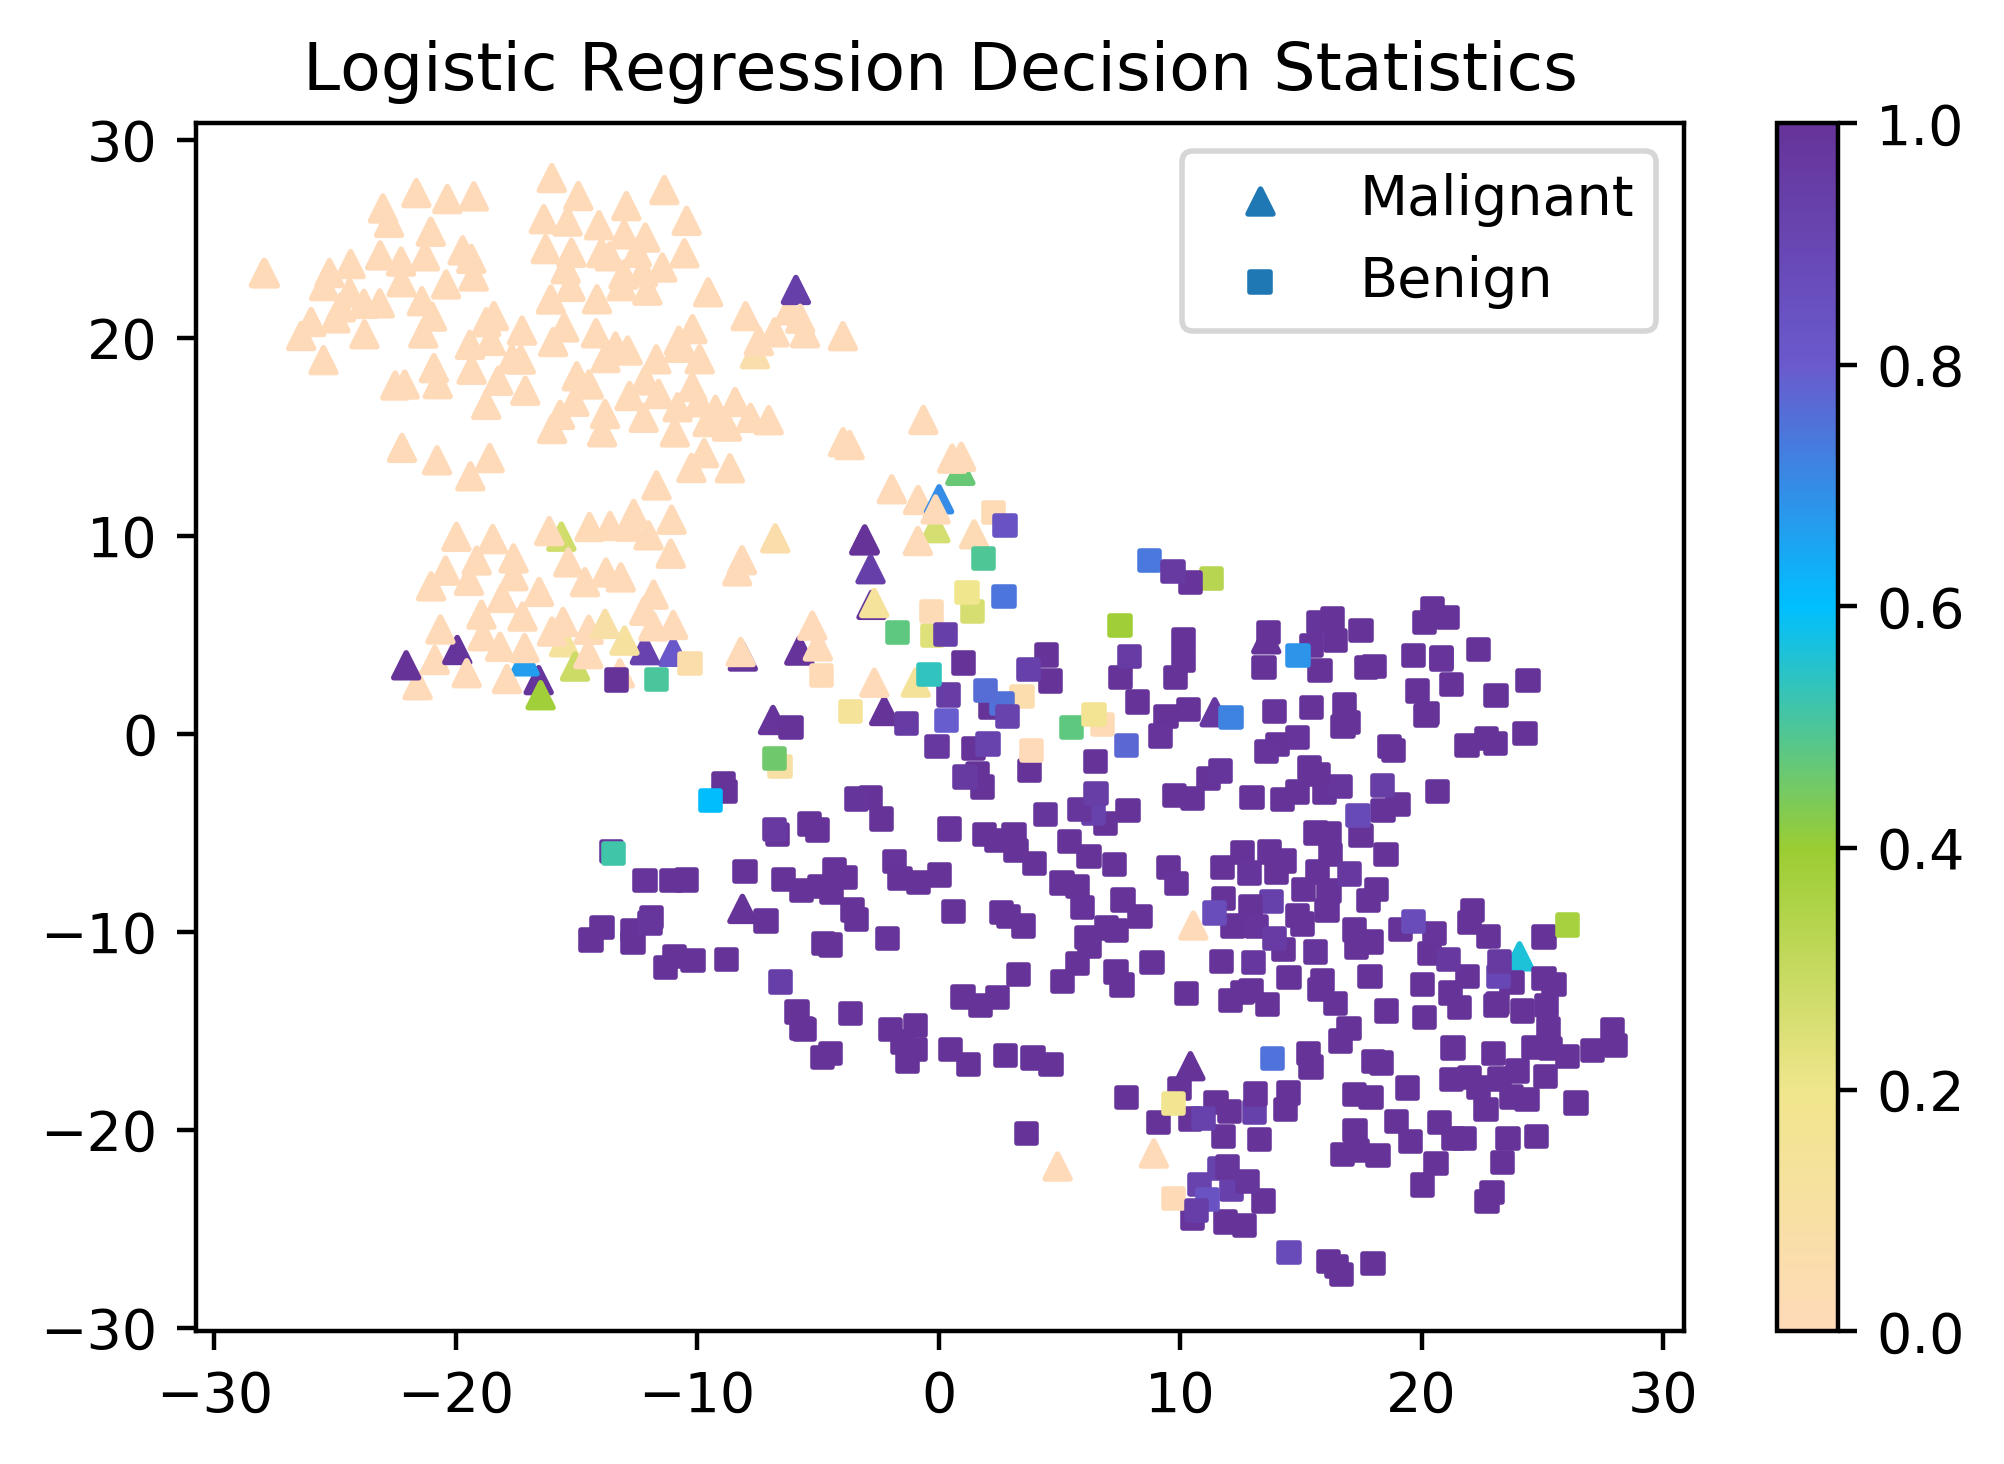

In [11]:
cm = LinearSegmentedColormap.from_list('my', colors, N=1000)
score_min = np.amin(scores_lr)
score_max = np.amax(scores_lr)
scores0 = scores_lr[y==0]
scores1 = scores_lr[y==1]
scores0[np.argmin(scores0)] = score_min
scores0[np.argmax(scores0)] = score_max
scores1[np.argmin(scores1)] = score_min
scores1[np.argmax(scores1)] = score_max
plt.figure(dpi=400)
plt.scatter(X_tsne[y==0][:,0], X_tsne[y==0][:,1], marker='^', s=20, c=scores0, cmap=cm, label='Malignant')
plt.scatter(X_tsne[y==1][:,0], X_tsne[y==1][:,1], marker='s', s=12, c=scores1, cmap=cm, label='Benign')
plt.colorbar()
plt.title("Logistic Regression Decision Statistics")
plt.legend()

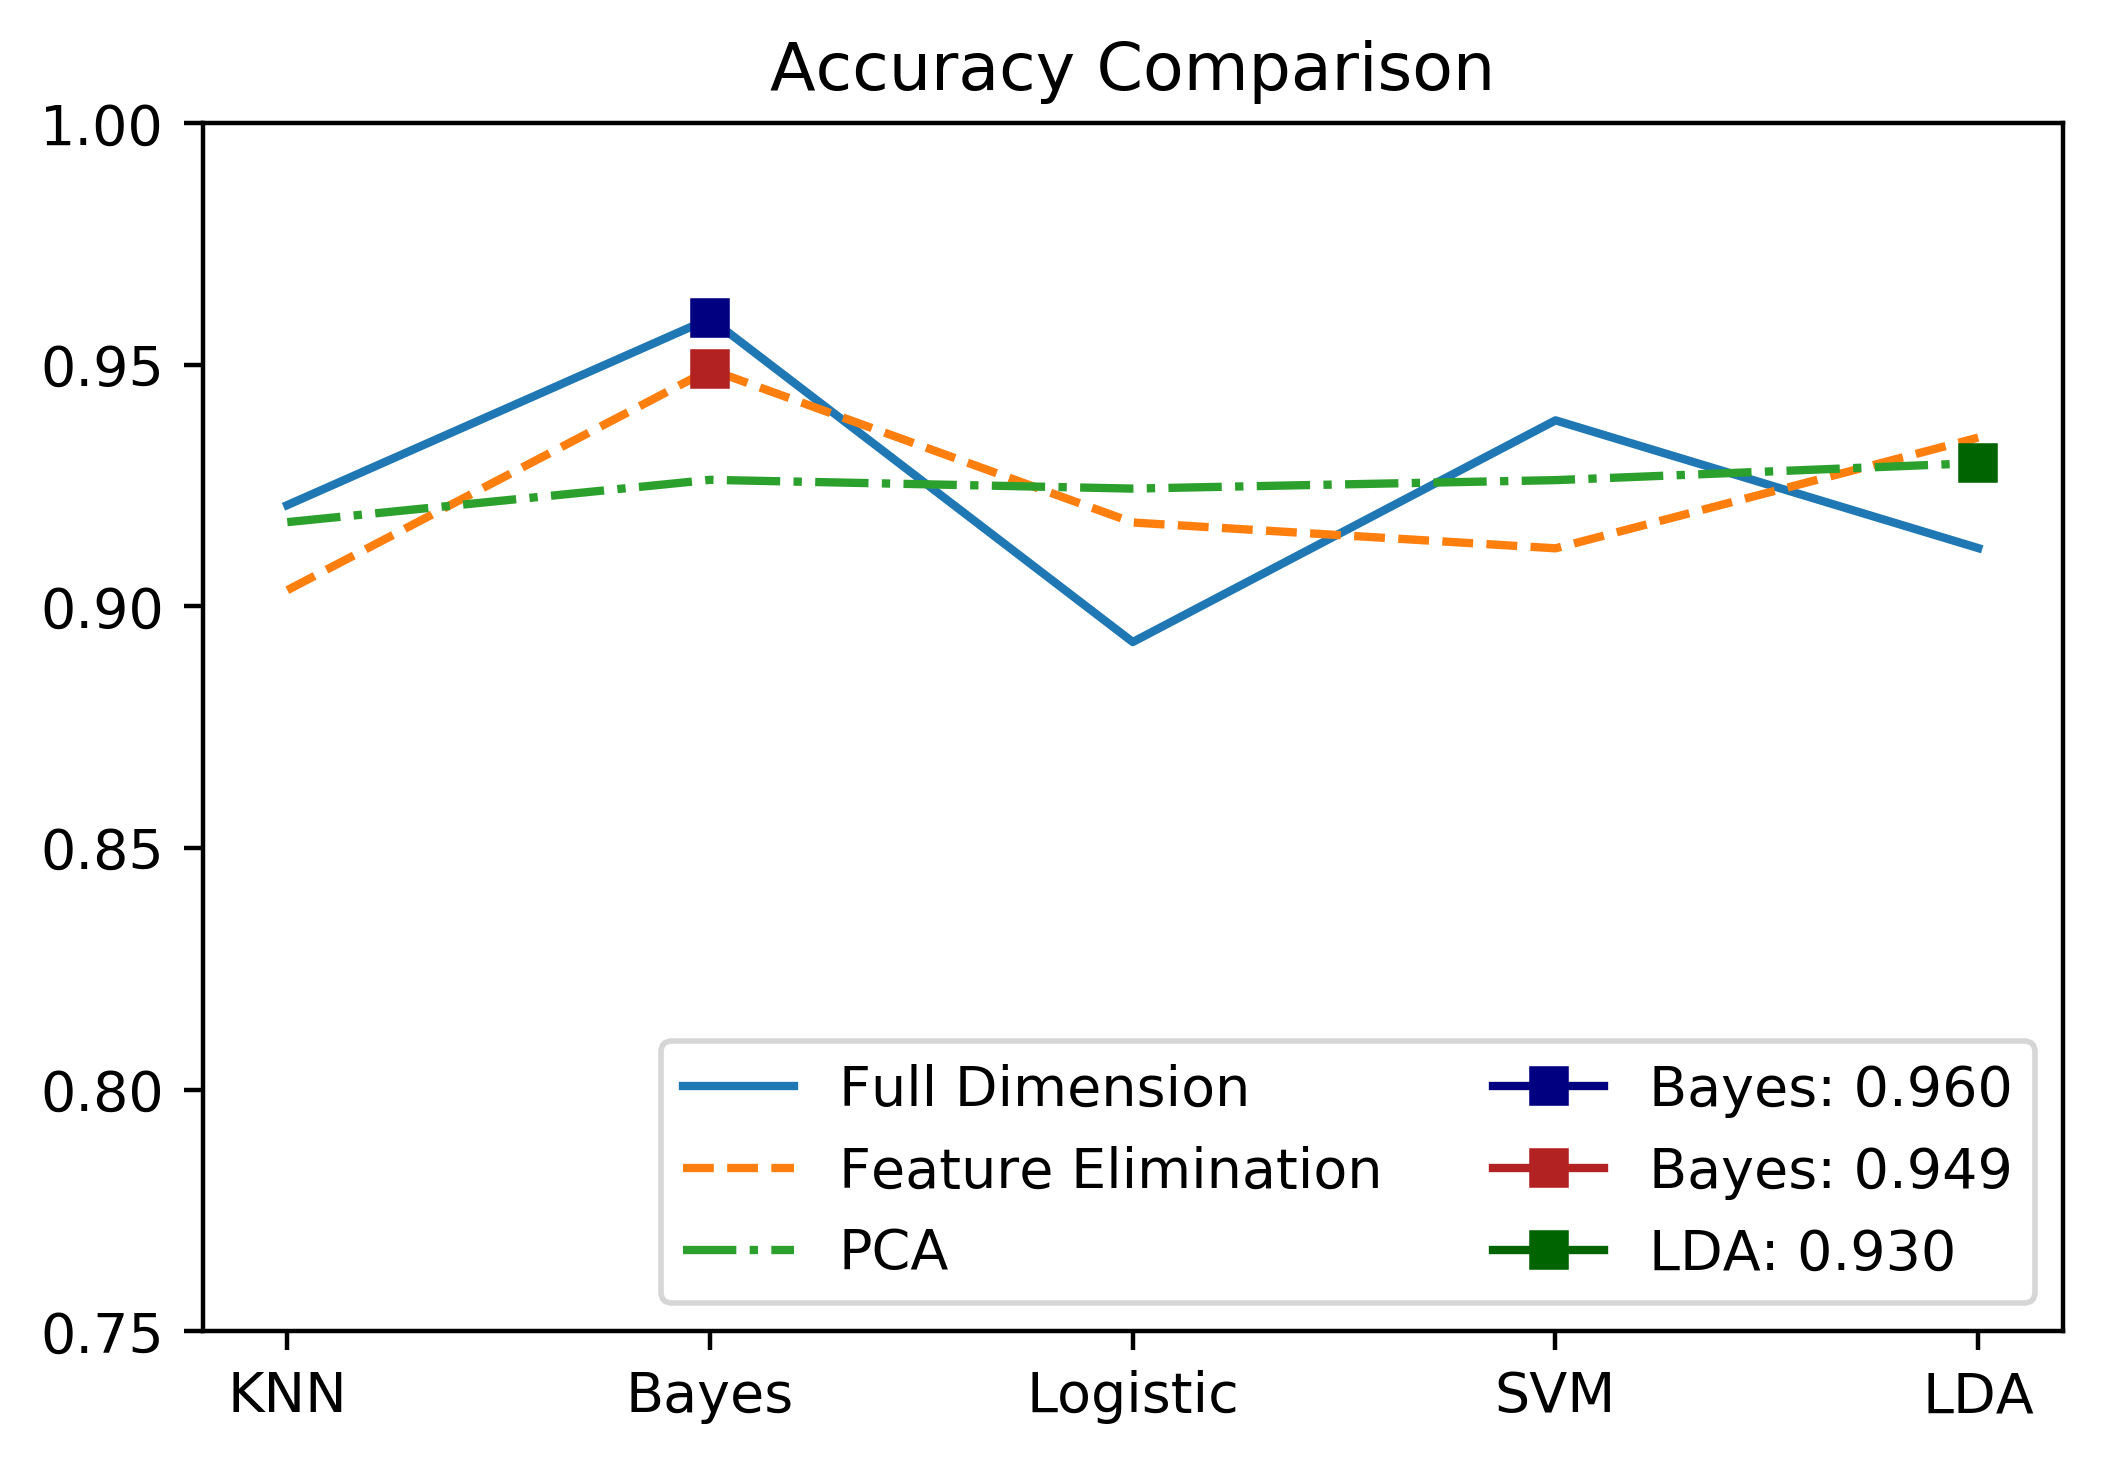

In [12]:
accuracy_knn = accuracy_knn.mean()
accuracy_bayes = accuracy_bayes.mean()
accuracy_lr = accuracy_lr.mean()
accuracy_svm = accuracy_svm.mean()
accuracy_lda = accuracy_lda.mean()

accuracy_knn_e = accuracy_knn_e.mean()
accuracy_bayes_e = accuracy_bayes_e.mean()
accuracy_lr_e = accuracy_lr_e.mean()
accuracy_svm_e = accuracy_svm_e.mean()
accuracy_lda_e = accuracy_lda_e.mean()

accuracy_knn_p = accuracy_knn_p.mean()
accuracy_bayes_p = accuracy_bayes_p.mean()
accuracy_lr_p = accuracy_lr_p.mean()
accuracy_svm_p = accuracy_svm_p.mean()
accuracy_lda_p = accuracy_lda_p.mean()

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.plot(['KNN', 'Bayes','Logistic','SVM','LDA'],[accuracy_knn, accuracy_bayes, accuracy_lr, accuracy_svm, accuracy_lda], label='Full Dimension')
plt.plot('Bayes', accuracy_bayes, marker='s', color='navy', label='Bayes: %.3f' %accuracy_bayes)
ax.plot(['KNN', 'Bayes','Logistic','SVM','LDA'],[accuracy_knn_e, accuracy_bayes_e, accuracy_lr_e, accuracy_svm_e, accuracy_lda_e], label='Feature Elimination', linestyle='--')
plt.plot('Bayes', accuracy_bayes_e, marker='s', color='firebrick', label='Bayes: %.3f' %accuracy_bayes_e)
ax.plot(['KNN', 'Bayes','Logistic','SVM','LDA'],[accuracy_knn_p, accuracy_bayes_p, accuracy_lr_p, accuracy_svm_p, accuracy_lda_p], label='PCA', linestyle='-.')
plt.plot('LDA', accuracy_lda_p, marker='s', color='darkgreen', label='LDA: %.3f' %accuracy_lda_p)
#plt.plot('SVM', accuracy_svm_p, marker='s', color='darkgreen')
ax.set_ylim([0.75, 1.0])
#ax.set_title('Accuracy Comparison')
plt.title('Accuracy Comparison')
#ax.legend(loc="lower right")
handles, labels = ax.get_legend_handles_labels()
plt.legend(flip(handles, 2), flip(labels, 2), loc=4, ncol=2)

In [13]:
accuracy_lda_p

0.9296537804688713